In [1]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.axes import Axes
from torch._prims_common import DeviceLikeType
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm, trange

from bioemu.so3_sde import angle_from_rotmat, rotmat_to_rotvec, rotvec_to_rotmat
from se3diff.finetune import compute_finetune_loss, reverse_finetune_diffusion
from se3diff.models import DiGMixSO3SDE, ScoreNet
from se3diff.train import (
    compute_train_loss,
    igso3_mixture_marginal_pdf,
    reverse_diffusion,
)

In [2]:
sde = DiGMixSO3SDE()
score_model = ScoreNet(rot_embed_dim=32, time_embed_dim=32, hidden_dim=128)
# finetune_model = ScoreNet(rot_embed_dim=8, time_embed_dim=8, hidden_dim=32)
finetune_model = ScoreNet(rot_embed_dim=16, time_embed_dim=16, hidden_dim=64)
# finetune_model = ScoreNet(rot_embed_dim=32, time_embed_dim=32, hidden_dim=128)
device = "cuda" if torch.cuda.is_available() else "cpu"

Computing dlog_igso3_expansion: 100%|██████████| 1000/1000 [00:01<00:00, 554.99it/s]


In [3]:
# Original model
mus = rotvec_to_rotmat(
    torch.tensor([[0.0, 0.0, 0.0], [0.0, math.pi / 2, 0.0], [0.0, 0.0, math.pi]])
)
sigmas = torch.tensor([0.1, 0.5, 0.2])
weights = torch.tensor([0.3, 0.1, 0.6])
print(f"Original model: \n{mus}")

# Fine-tuned model
# mus_finetune = rotvec_to_rotmat(
#     torch.tensor([[0.0, 0.0, 0.0], [0.0, 0.0, math.pi]]) + torch.randn(2, 3) * 0.05
# )
# sigmas_finetune = torch.tensor([0.2, 0.1])
# weights_finetune = torch.tensor([0.6, 0.4])
mus_finetune = mus.clone()
sigmas_finetune = sigmas.clone()
weights_finetune = torch.tensor([0.4, 0.2, 0.4])
print(f"Fine-tuned model: \n{mus_finetune}")

Original model: 
tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [-1.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.0000e+00,  8.7423e-08,  0.0000e+00],
         [-8.7423e-08, -1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]])
Fine-tuned model: 
tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 0.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00],
         [-1.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[-1.0000e+00,  8.7423e-08,  0.0000e+00],
         [-8.7423e-08, -1.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00]]])


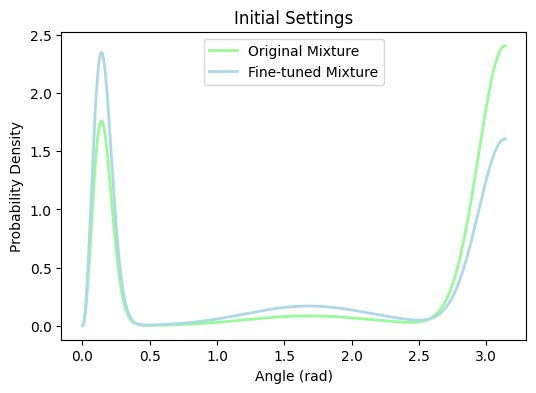

In [4]:
def visualize_initial_settings(
    mus: torch.Tensor,
    sigmas: torch.Tensor,
    weights: torch.Tensor,
    mus_finetune: torch.Tensor,
    sigmas_finetune: torch.Tensor,
    weights_finetune: torch.Tensor,
) -> None:
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.set_title("Initial Settings")
    omega, pdf = igso3_mixture_marginal_pdf(mus, sigmas, weights)
    omega_finetune, pdf_finetune = igso3_mixture_marginal_pdf(
        mus_finetune, sigmas_finetune, weights_finetune
    )
    ax.plot(
        omega.cpu().numpy(),
        pdf.cpu().numpy(),
        color="palegreen",
        lw=2,
        label="Original Mixture",
    )
    ax.plot(
        omega_finetune.cpu().numpy(),
        pdf_finetune.cpu().numpy(),
        color="lightblue",
        lw=2,
        label="Fine-tuned Mixture",
    )
    ax.set_xlabel("Angle (rad)")
    ax.set_ylabel("Probability Density")
    ax.legend()
    plt.show()


visualize_initial_settings(
    mus,
    sigmas,
    weights,
    mus_finetune,
    sigmas_finetune,
    weights_finetune,
)

In [ ]:
def train(
    sde: DiGMixSO3SDE,
    score_model: nn.Module,
    mus: torch.Tensor,
    sigmas: torch.Tensor,
    weights: torch.Tensor,
    *,
    device: DeviceLikeType | None = None,
    epochs: int = 20,
    batch_size: int = 4096,
    num_steps: int = 200,
    lr: float = 5e-3,
    weight_decay: float = 1e-4,
    eta_min: float = 1e-5,
    tol: float = 1e-7,
):
    # instantiate SDE and score model
    sde.to(device)
    score_model.to(device)

    # instantiate the mixture parameters
    mus = mus.to(device)
    sigmas = sigmas.to(device)
    weights = weights.to(device)

    optimizer = AdamW(score_model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=eta_min)

    for epoch in range(1, epochs + 1):
        score_model.train()
        epoch_loss = 0.0
        pbar = tqdm(range(num_steps), desc=f"Epoch {epoch}", leave=False)
        for _ in pbar:
            loss = compute_train_loss(
                sde,
                score_model,
                mus,
                sigmas,
                weights,
                device=device,
                batch_size=batch_size,
                tol=tol,
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            l = loss.detach().item()
            epoch_loss += l
            pbar.set_postfix(loss=f"{l:.2f}")

        scheduler.step()
        avg_loss = epoch_loss / num_steps
        print(f"Epoch {epoch}: Average training loss = {avg_loss:.4f}")

        if epoch % 10 == 0:
            score_model.eval()
            with torch.no_grad():
                val_loss = compute_train_loss(
                    sde,
                    score_model,
                    mus,
                    sigmas,
                    weights,
                    device=device,
                    batch_size=batch_size,
                    tol=tol,
                )
            print(f"Validation loss: {val_loss:.4f}")


train(
    sde,
    score_model,
    mus,
    sigmas,
    weights,
    device=device,
)
# save the model
torch.save(score_model.state_dict(), "score_model.pt")
# load the model
score_model.load_state_dict(torch.load("score_model.pt"))

Reverse diffusion:   0%|          | 0/2000 [00:00<?, ?it/s]

Plotting:   0%|          | 0/8 [00:00<?, ?it/s]

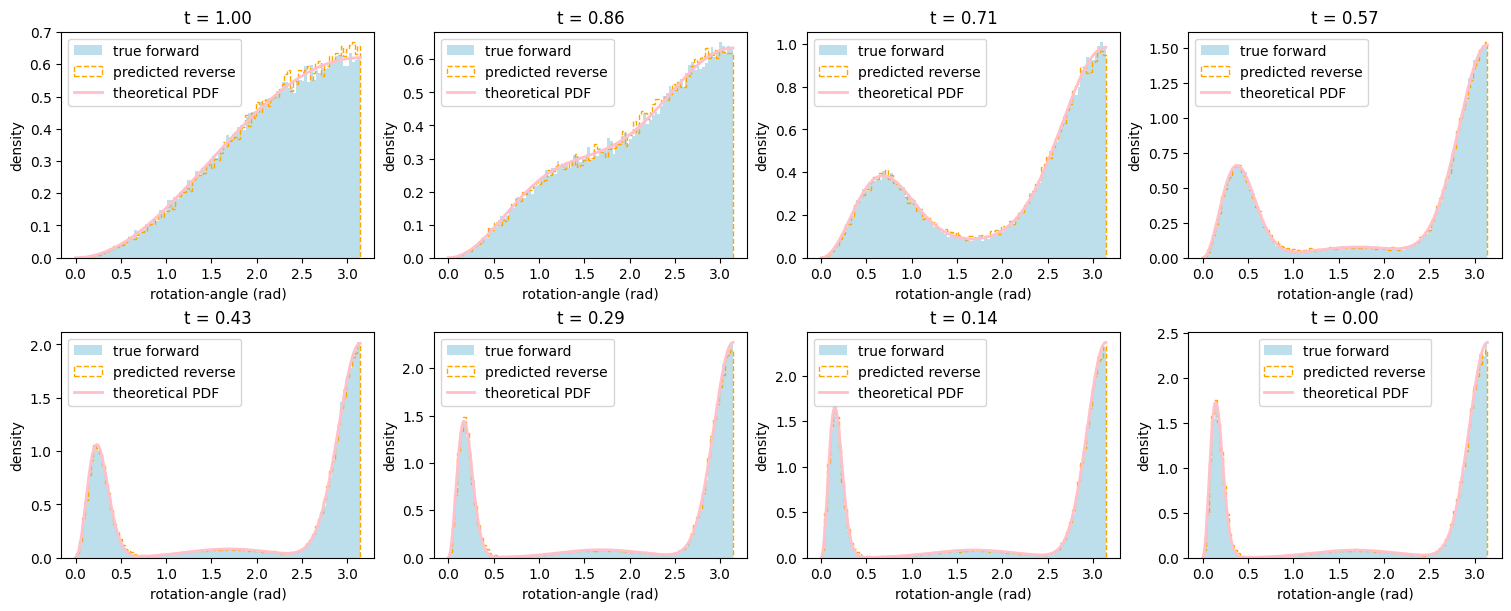

In [5]:
@torch.no_grad()
def visualize_diffusion(
    sde: DiGMixSO3SDE,
    score_model: nn.Module,
    mus: torch.Tensor,
    sigmas: torch.Tensor,
    weights: torch.Tensor,
    *,
    device: DeviceLikeType | None = None,
    batch_size: int = 65536,
    num_steps: int = 2000,
    t_num: int = 8,
    l_max: int = 1000,
    num_points: int = 1000,
    tol: float = 1e-7,
):
    sde.to(device)
    score_model.to(device).eval()

    mus = mus.to(device)
    sigmas = sigmas.to(device)
    weights = weights.to(device)

    # reverse diffusion samples
    xs, t_vals = reverse_diffusion(
        sde, score_model, device=device, batch_size=batch_size, num_steps=num_steps
    )

    x_0 = sde.sample_multiple_igso3(
        mus, sigmas, weights, batch_size, device=device
    )  # (B,3,3)

    # pick checkpoints
    idxs = np.linspace(0, num_steps, t_num, dtype=int)
    fig, axes = plt.subplots(
        2, int(np.ceil(t_num / 2)), figsize=(15, 6), constrained_layout=True
    )
    axes: np.ndarray = axes.flatten()

    for i in trange(t_num, desc="Plotting", leave=False):
        # plot forward and reverse marginals
        ax: Axes = axes[i]
        idx = idxs[i]
        t_val = t_vals[idx].item()
        t = torch.full((batch_size,), t_val, device=device)

        # a) true forward histogram
        x_t = sde.sample_marginal(x_0, t)
        true_angles = angle_from_rotmat(x_t)[0]
        ax.hist(
            true_angles.cpu().numpy(),
            bins=100,
            density=True,
            alpha=0.8,
            label="true forward",
            color="lightblue",
        )

        # b) predicted reverse histogram
        x_rev = xs[idx]
        rev_angles = angle_from_rotmat(x_rev)[0]
        ax.hist(
            rev_angles.cpu().numpy(),
            bins=100,
            density=True,
            histtype="step",
            linestyle="--",
            linewidth=1,
            label="predicted reverse",
            color="orange",
        )

        # c) theoretical forward marginal (vectorized)
        sigma_t = torch.sqrt(sde._marginal_std(t_vals[idx]) ** 2 + sigmas**2)  # (K,)
        omega, pdf = igso3_mixture_marginal_pdf(
            mus,
            sigma_t,
            weights,
            l_max=l_max,
            num_points=num_points,
            tol=tol,
        )

        ax.plot(
            omega.cpu().numpy(),
            pdf.cpu().numpy(),
            color="pink",
            lw=2,
            label="theoretical PDF",
        )

        ax.set_title(f"t = {t_val:.2f}")
        ax.set_xlabel("rotation-angle (rad)")
        ax.set_ylabel("density")
        ax.legend()

    plt.show()


score_model.load_state_dict(torch.load("score_model.pt", map_location=device))
visualize_diffusion(sde, score_model, mus, sigmas, weights, device=device)

In [4]:
def finetune(
    sde: DiGMixSO3SDE,
    score_model: nn.Module,
    finetune_model: nn.Module,
    mus: torch.Tensor,
    sigmas: torch.Tensor,
    weights: torch.Tensor,
    *,
    device: DeviceLikeType | None = None,
    lambda_: float = 0.2,
    epochs: int = 50,
    batch_size: int = 4096,
    num_steps: int = 200,
    l_max: int = 1000,
    lr: float = 5e-3,
    weight_decay: float = 1e-4,
    eta_min: float = 1e-5,
    tol: float = 1e-7,
):
    # instantiate SDE and score model
    sde.to(device)
    score_model.to(device).eval()
    finetune_model.to(device)

    # instantiate the mixture parameters
    mus = mus.to(device)
    sigmas = sigmas.to(device)
    weights = weights.to(device)

    optimizer = AdamW(finetune_model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=eta_min)

    for epoch in trange(1, epochs + 1, desc="Epochs", leave=False):
        finetune_model.train()
        loss = compute_finetune_loss(
            sde,
            score_model,
            finetune_model,
            mus,
            sigmas,
            weights,
            lambda_=lambda_,
            device=device,
            batch_size=batch_size,
            num_steps=num_steps,
            l_max=l_max,
            tol=tol,
        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_loss = loss.detach().item()

        scheduler.step()
        print(f"Epoch {epoch}: Average training loss = {avg_loss:.4f}")

        if epoch % 10 == 0:
            finetune_model.eval()
            with torch.no_grad():
                val_loss = compute_finetune_loss(
                    sde,
                    score_model,
                    finetune_model,
                    mus,
                    sigmas,
                    weights,
                    lambda_=lambda_,
                    device=device,
                    batch_size=batch_size,
                    num_steps=num_steps,
                    l_max=l_max,
                    tol=tol,
                )
            print(f"Validation loss: {val_loss:.4f}")


score_model.load_state_dict(torch.load("score_model.pt", map_location=device))
finetune(
    sde,
    score_model,
    finetune_model,
    mus_finetune,
    sigmas_finetune,
    weights_finetune,
    device=device,
    lambda_=0.2,
)
# save the model
torch.save(finetune_model.state_dict(), "finetune_model.pt")
# load the model
finetune_model.load_state_dict(torch.load("finetune_model.pt"))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1: Average training loss = 0.0586


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 2: Average training loss = 0.0531


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 3: Average training loss = 0.0452


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 4: Average training loss = 0.0462


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 5: Average training loss = 0.0351


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 6: Average training loss = 0.0372


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 7: Average training loss = 0.0317


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 8: Average training loss = 0.0407


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 9: Average training loss = 0.0259


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 10: Average training loss = 0.0260


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Validation loss: 0.0309


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 11: Average training loss = 0.0236


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 12: Average training loss = 0.0223


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 13: Average training loss = 0.0290


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 14: Average training loss = 0.0223


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 15: Average training loss = 0.0244


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 16: Average training loss = 0.0215


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 17: Average training loss = 0.0203


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 18: Average training loss = 0.0181


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 19: Average training loss = 0.0183


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 20: Average training loss = 0.0155


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Validation loss: 0.0178


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 21: Average training loss = 0.0181


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 22: Average training loss = 0.0180


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 23: Average training loss = 0.0160


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 24: Average training loss = 0.0198


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 25: Average training loss = 0.0214


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 26: Average training loss = 0.0208


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 27: Average training loss = 0.0178


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 28: Average training loss = 0.0150


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 29: Average training loss = 0.0127


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 30: Average training loss = 0.0133


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Validation loss: 0.0116


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 31: Average training loss = 0.0117


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 32: Average training loss = 0.0142


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 33: Average training loss = 0.0075


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 34: Average training loss = 0.0148


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 35: Average training loss = 0.0180


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 36: Average training loss = 0.0179


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 37: Average training loss = 0.0135


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 38: Average training loss = 0.0138


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 39: Average training loss = 0.0169


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 40: Average training loss = 0.0164


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Validation loss: 0.0121


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 41: Average training loss = 0.0139


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 42: Average training loss = 0.0116


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 43: Average training loss = 0.0126


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 44: Average training loss = 0.0138


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 45: Average training loss = 0.0160


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 46: Average training loss = 0.0118


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 47: Average training loss = 0.0140


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 48: Average training loss = 0.0150


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 49: Average training loss = 0.0155


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 50: Average training loss = 0.0136


Reverse diffusion:   0%|          | 0/200 [00:00<?, ?it/s]

Validation loss: 0.0156


<All keys matched successfully>

Reverse diffusion:   0%|          | 0/2000 [00:00<?, ?it/s]

Plotting:   0%|          | 0/8 [00:00<?, ?it/s]

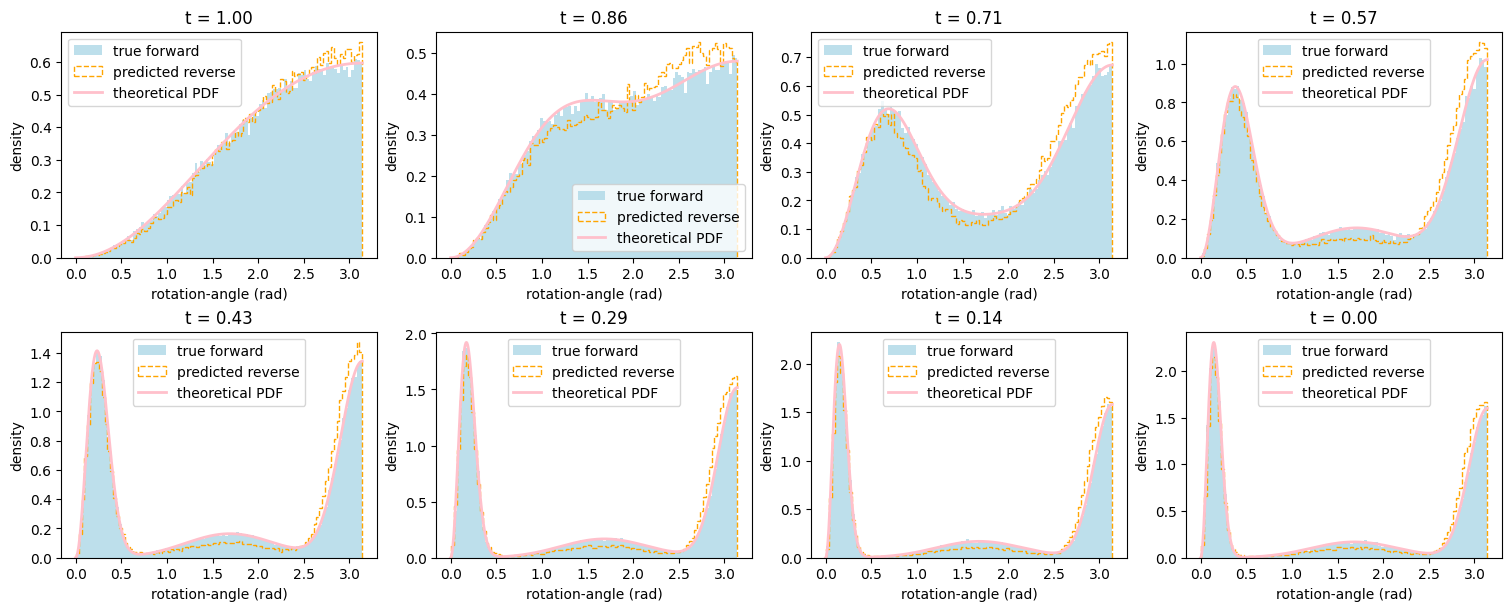

In [5]:
@torch.no_grad()
def visualize_finetune_diffusion(
    sde: DiGMixSO3SDE,
    score_model: nn.Module,
    finetune_model: nn.Module,
    mus: torch.Tensor,
    sigmas: torch.Tensor,
    weights: torch.Tensor,
    *,
    device: DeviceLikeType | None = None,
    batch_size: int = 65536,
    num_steps: int = 2000,
    t_num: int = 8,
    l_max: int = 1000,
    num_points: int = 1000,
    tol: float = 1e-7,
):
    sde.to(device)
    score_model.to(device).eval()
    finetune_model.to(device).eval()

    mus = mus.to(device)
    sigmas = sigmas.to(device)
    weights = weights.to(device)

    # reverse diffusion samples
    xs, t_vals, *_ = reverse_finetune_diffusion(
        sde,
        score_model,
        finetune_model,
        device=device,
        batch_size=batch_size,
        num_steps=num_steps,
    )

    x_0 = sde.sample_multiple_igso3(
        mus, sigmas, weights, batch_size, device=device
    )  # (B,3,3)

    # pick checkpoints
    idxs = np.linspace(0, num_steps, t_num, dtype=int)
    fig, axes = plt.subplots(
        2, int(np.ceil(t_num / 2)), figsize=(15, 6), constrained_layout=True
    )
    axes: np.ndarray = axes.flatten()

    for i in trange(t_num, desc="Plotting", leave=False):
        # plot forward and reverse marginals
        ax: Axes = axes[i]
        idx = idxs[i]
        t_val = t_vals[idx].item()
        t = torch.full((batch_size,), t_val, device=device)

        # a) true forward histogram
        x_t = sde.sample_marginal(x_0, t)
        true_angles = angle_from_rotmat(x_t)[0]
        ax.hist(
            true_angles.cpu().numpy(),
            bins=100,
            density=True,
            alpha=0.8,
            label="true forward",
            color="lightblue",
        )

        # b) predicted reverse histogram
        x_rev = xs[idx]
        rev_angles = angle_from_rotmat(x_rev)[0]
        ax.hist(
            rev_angles.cpu().numpy(),
            bins=100,
            density=True,
            histtype="step",
            linestyle="--",
            linewidth=1,
            label="predicted reverse",
            color="orange",
        )

        # c) theoretical forward marginal (vectorized)
        sigma_t = torch.sqrt(sde._marginal_std(t_vals[idx]) ** 2 + sigmas**2)  # (K,)
        omega, pdf = igso3_mixture_marginal_pdf(
            mus,
            sigma_t,
            weights,
            l_max=l_max,
            num_points=num_points,
            tol=tol,
        )

        ax.plot(
            omega.cpu().numpy(),
            pdf.cpu().numpy(),
            color="pink",
            lw=2,
            label="theoretical PDF",
        )

        ax.set_title(f"t = {t_val:.2f}")
        ax.set_xlabel("rotation-angle (rad)")
        ax.set_ylabel("density")
        ax.legend()

    plt.show()


score_model.load_state_dict(torch.load("score_model.pt", map_location=device))
finetune_model.load_state_dict(torch.load("finetune_model.pt", map_location=device))
visualize_finetune_diffusion(
    sde,
    score_model,
    finetune_model,
    mus_finetune,
    sigmas_finetune,
    weights_finetune,
    device=device,
)